In [1]:
# create a simulated dataset incorporating multiple features for two distinct groups: A and B
# assumption 1: assume the two groups are both taking the BMI index test, group A is the normal people, group B is the obese people
# assumption 2: assume the both group have a normal distribution of BMI index

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, gamma, norm

In [2]:
# a functuion to generate a truncated gamma distribution from 0-1
def truncated_gamma(shape, scale, size, lower_bound=0, upper_bound=4):
    samples = []
    while len(samples) < size:
        sample = np.random.gamma(shape, scale)
        if lower_bound <= sample <= upper_bound:
            samples.append(sample)
    return np.array(samples)

# random parameters for the truncated gamma distribution
shape = 2.0  
scale = 1.0 
size = 100 

# generate the samples
samples = truncated_gamma(shape, scale, size)

In [3]:
# use height randomly choose gender
def decide_gender(height):
    if height <= 172:
        # if height is less than 172, we assume 70% probability of being female
        return np.random.choice(['Male', 'Female'], p=[0.3, 0.7])
    else:
        # otherwise, we assume 80% probability of being male
        return np.random.choice(['Male', 'Female'], p=[0.8, 0.2])

In [4]:
# decide if ED
def decide_ed(row):
    if row['bmi'] > 30 and row['gender'] == 'Male':
        # for BMI index greater than 30
        return np.random.choice(['Yes', 'No'], p=[0.8, 0.2])
    else:
        # others
        return 'No'

In [5]:
# generate random data for group A (BMI index between 18.5 - 24.9)
np.random.seed(0)
A_height = np.random.normal(173, 10, 100)
A_height -= samples
# # use average BMI index 21 to deduce the weight
# A_weight = np.random.normal(22 * (1.7 ** 2), 3, 1000)

shape_param = 2
scale_param = 30
A_weight = gamma.rvs(a=shape_param, scale=scale_param, size=100)

normal_bmi_lower = 18.5
normal_bmi_upper = 24.9

# calculate the BMI index
A_bmi = A_weight / (A_height / 100) ** 2
# assume the age of prople is between 25-35

adjusted_A_weight = []
for i in range(len(A_bmi)):
    if A_bmi[i] < normal_bmi_lower:
        # 对于BMI过低的情况，增加体重
        adjusted_bmi = np.random.uniform(low=normal_bmi_lower-4, high=normal_bmi_upper-4)
    elif A_bmi[i] > normal_bmi_upper:
        # 对于BMI过高的情况，减少体重
        adjusted_bmi = np.random.uniform(low=normal_bmi_lower+4, high=normal_bmi_upper+4)
    else:
        # 如果BMI已在正常范围内，则不调整
        adjusted_bmi = A_bmi[i]
    
    # 根据调整后的BMI反向计算体重
    adjusted_weight = adjusted_bmi * (A_height[i]/100)**2
    adjusted_A_weight.append(adjusted_weight)

adjusted_A_bmi = adjusted_A_weight / (A_height / 100) ** 2

A_age = np.random.normal(30, 5, 100)

# use pandas to create a dataframe for group A
A = pd.DataFrame({'height': A_height, 'weight': adjusted_A_weight, 'bmi': adjusted_A_bmi, 'age': A_age, 'group': 'A'})

# generate gender
A['gender'] = A['height'].apply(decide_gender)

# generate ED
A['ed'] = A.apply(decide_ed, axis=1)

# visual the data
print(A.head(10))

       height     weight        bmi        age group  gender  ed
0  190.055596  84.251479  23.324708  31.950467     A  Female  No
1  175.861553  52.616976  17.013124  35.392896     A    Male  No
2  181.247888  67.741617  20.620997  27.406330     A    Male  No
3  193.369734  88.609861  23.697638  28.592368     A    Male  No
4  190.298456  73.460890  20.285497  32.801847     A    Male  No
5  161.653616  46.986076  17.980358  33.776045     A  Female  No
6  179.854012  82.240950  25.424233  24.695546     A    Male  No
7  169.215172  80.589945  28.145065  30.272369     A    Male  No
8  169.653620  50.182217  17.435065  29.478607     A    Male  No
9  176.553335  84.581706  27.134673  28.241952     A    Male  No


In [6]:
# generate random data for group B (over 30)
np.random.seed(0)
B_height = np.random.normal(170, 10, 100)
# use average BMI index 35 to deduce the weight
B_weight = np.random.normal(35 * (1.7 ** 2), 5, 100)
# calculate the BMI index
B_bmi = B_weight / (B_height / 100) ** 2
# assume the age of prople is between 25-35
B_age = np.random.normal(30, 5, 100)

# use pandas to create a dataframe for group B
B = pd.DataFrame({'height': B_height, 'weight': B_weight, 'bmi': B_bmi, 'age': B_age, 'group': 'B'})

# decide gender
B['gender'] = B['height'].apply(decide_gender)

# decide ED
B['ed'] = B.apply(decide_ed, axis=1)

# visual the data
print(B.head(10))


       height      weight        bmi        age group  gender   ed
0  187.640523  110.565753  31.402727  28.154091     B    Male   No
1  174.001572   94.411205  31.182950  28.803104     B    Male  Yes
2  179.787380   94.797575  29.327755  35.498298     B    Male   No
3  192.408932  105.996984  28.631431  33.276319     B    Male   No
4  188.675580   95.284383  26.766423  33.200658     B    Male   No
5  160.227221  110.868106  43.185110  21.915220     B  Female   No
6  179.500884   99.081905  30.751136  29.878369     B    Male  Yes
7  168.486428   97.412726  34.315146  26.309845     B  Female   No
8  168.967811  110.764710  38.796581  31.399623     B  Female   No
9  174.105985  108.552574  35.810693  29.509248     B    Male  Yes


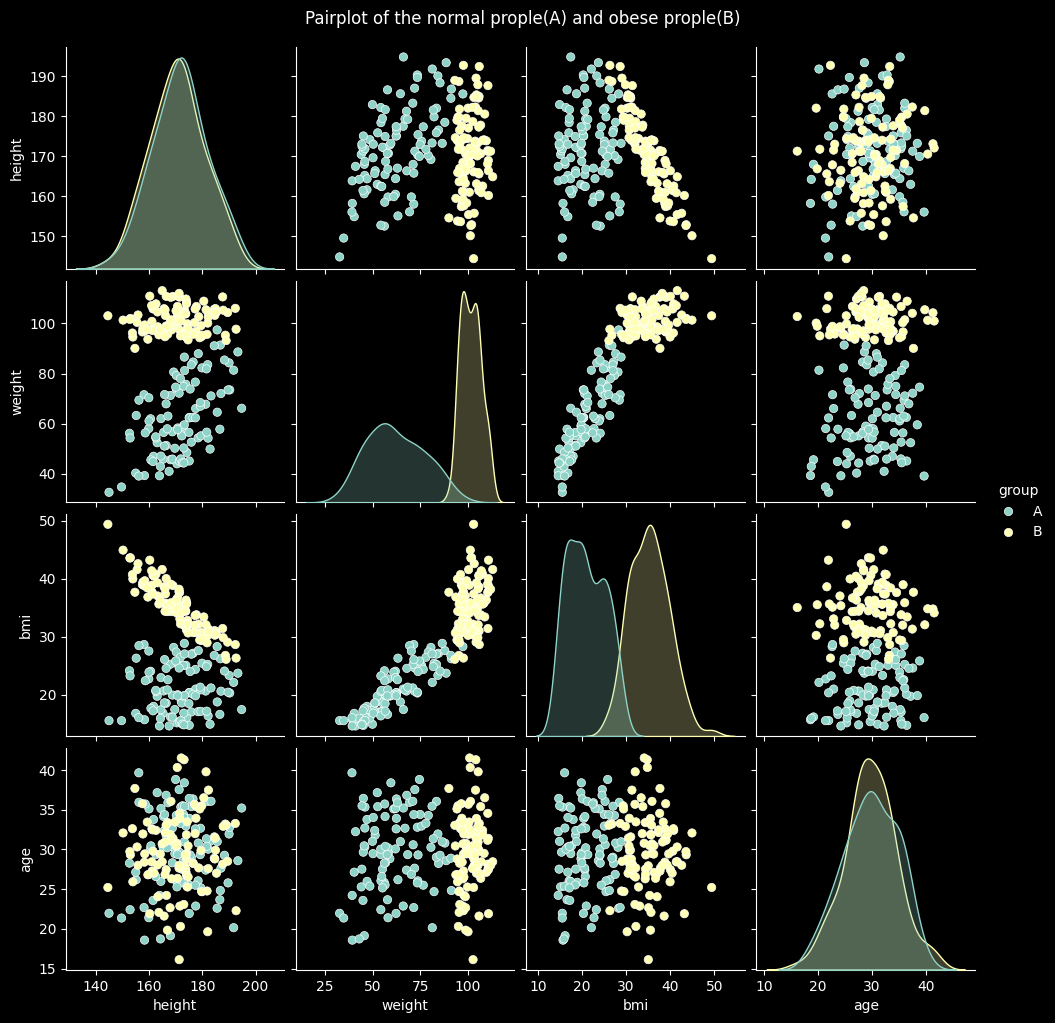

In [7]:
# cancatenate the two groups
data = pd.concat([A, B])

# use seaborn to visual the data
vis = sns.pairplot(data, hue='group')
vis.fig.suptitle('Pairplot of the normal prople(A) and obese prople(B)', y=1.02)
plt.show()

In [8]:
# compare the BMI index of group A and B using ttest
t_stat, p_val = ttest_ind(A['bmi'], B['bmi'])
print(f'The t-statistic is {t_stat} and the p-value is {p_val}')

The t-statistic is -23.57415602249371 and the p-value is 2.2046279209835628e-59


In [10]:
ed_distribution = data['ed'].value_counts()
print(ed_distribution)

ed
No     157
Yes     43
Name: count, dtype: int64


In [11]:
ed_gender_distribution = data[data['ed'] == 'Yes']['gender'].value_counts()
print("Gender distribution among individuals with ED:")
print(ed_gender_distribution)

Gender distribution among individuals with ED:
gender
Male    43
Name: count, dtype: int64


In [12]:
ed_bmi_distribution = data[data['ed'] == 'Yes']['bmi']
print("BMI distribution among individuals with ED:")
print(ed_bmi_distribution.describe())

BMI distribution among individuals with ED:
count    43.000000
mean     34.542219
std       3.755358
min      30.214446
25%      31.242895
50%      34.063516
75%      36.291946
max      43.601610
Name: bmi, dtype: float64


In [14]:
ed_group_by_gender_bmi = data[data['ed'] == 'Yes'].groupby('gender')['bmi'].describe()
print("BMI distribution among individuals with ED by gender:")
print(ed_group_by_gender_bmi)

BMI distribution among individuals with ED by gender:
        count       mean       std        min        25%        50%  \
gender                                                                
Male     43.0  34.542219  3.755358  30.214446  31.242895  34.063516   

              75%       max  
gender                       
Male    36.291946  43.60161  


Reference
- The codes are wriiten under the help of Chatgpt
https://chat.openai.com/share/e8f7ae6c-074b-460d-8d73-8c7ff459e0bb